In [1]:

import torch
import math
import chime
from data_loader import NEFG3x3Set
from AE import AE
from AE import CustomLoss
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev) 
torch.cuda.set_device(0) 
# Download the MNIST Dataset
dataset = NEFG3x3Set("info_dat_charge.csv",
                     "data/3x12_16_damp00", "dat_charge", transform=True)

length = len(dataset)
train_split = math.floor(length*.7)
test_split = length - train_split

train_inds, test_inds = torch.utils.data.random_split(
    dataset, [train_split, test_split], generator=torch.Generator().manual_seed(42))


# Model Initialization
model = AE().to(dev)

# Validation using MSE Loss function
loss_function = torch.nn.L1Loss()

# Using an Adam Optimizer with lr = 0.
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4)

train_data = torch.utils.data.DataLoader(dataset=train_inds, batch_size=32,
                                         shuffle=True)
test_data = torch.utils.data.DataLoader(dataset=test_inds, batch_size=32,
                                        shuffle=True)


In [2]:
epochs = 10
outputs = []
losses = []
local_loss  = 0
txt1 = "Epoch {epoch} / "+str(epochs)
txt2 = "Average training loss: {loss}"
txt3 = "Average test loss: {loss}"


for epoch in range(epochs):
    if epoch%10==0:
        clear_output(wait=True)
    print(txt1.format(epoch = epoch))
    for (inp,_ , tar, _,_,_) in train_data:
        model.train()
        inp = inp.reshape(-1, 71*26).float()
        tar = tar.reshape(-1, 71*26).float()
        # Output of Autoencoder
        reconstructed = model(inp)

        # Calculating the loss function
        loss = loss_function(reconstructed, tar)
        
        local_loss=local_loss+loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    print(txt2.format(loss = local_loss/len(train_data)))
    losses.append(local_loss/len(test_data))
    local_loss = 0
    
    for (inp, cmpr,tar, _,_,_) in test_data:
        model.eval()
        
        inp = inp.reshape(-1, 71*26).float()
        tar = tar.reshape(-1, 71*26).float()
        
        # Output of Autoencoder
        reconstructed = model(inp)

        # Calculating the loss function
        loss = loss_function(reconstructed, tar)
        local_loss+=loss

    
    print(txt3.format(loss = local_loss/len(test_data)))
    
    local_loss = 0

chime.success()


Epoch 0 / 10
Average training loss: 0.009035279043018818
Average test loss: 0.006918713450431824
Epoch 1 / 10
Average training loss: 0.007132884580641985
Average test loss: 0.006955127231776714
Epoch 2 / 10
Average training loss: 0.007118772249668837
Average test loss: 0.0068891579285264015
Epoch 3 / 10
Average training loss: 0.007117731496691704
Average test loss: 0.006868594326078892
Epoch 4 / 10
Average training loss: 0.007099466864019632
Average test loss: 0.006849213037639856
Epoch 5 / 10
Average training loss: 0.007103058509528637
Average test loss: 0.0068923961371183395
Epoch 6 / 10
Average training loss: 0.007132046390324831
Average test loss: 0.006891610100865364
Epoch 7 / 10
Average training loss: 0.007184972055256367
Average test loss: 0.006852385122328997
Epoch 8 / 10
Average training loss: 0.0071180434897542
Average test loss: 0.0069331759586930275
Epoch 9 / 10
Average training loss: 0.007126376032829285
Average test loss: 0.006928744725883007


tensor(0.0166, device='cuda:0', grad_fn=<DivBackward0>)


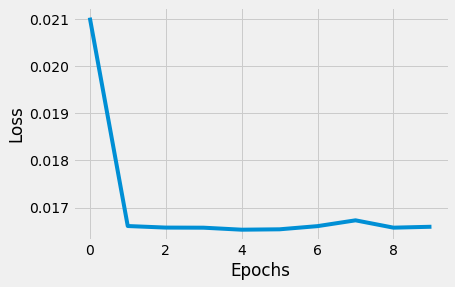

In [3]:
# torch.save(model.state_dict(), "trained_models/3x12_16_pot_10.mp")
# torch.save(model, "trained_models/3x3_12_charge.pt")
# 0.001485698390752077
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Plotting the last 100 values
a = [i.cpu().detach().numpy() for i in losses]
print(losses[-1])
plt.plot(a)
plt.show()
# 0.04351815581321716

In [4]:
# Loss is 0.0219
# 
# 1600
# 1500 - example of very small data
# 1000 - very small nums
# 3000 - bigger numbers
#
Lf = torch.nn.L1Loss()

loss_og =0
loss_cmp=0
loss_inp=0

for (inp, cmpr ,tar, _, _, _) in dataset:
    
    inp = inp.reshape(71*26).float()
    cmpr = cmpr.reshape(71*26).float()
    tar = tar.reshape(71*26).float()
    # print(inp.shape)
    rec = model(inp).float().reshape(71* 26)
    loss_inp += Lf(tar, inp).item()
    loss_cmp += Lf(tar, cmpr).item()
    loss_og += Lf(tar, rec).item()
    
print(loss_inp/len(dataset))
print(loss_og/len(dataset))
print(loss_cmp/len(dataset))

    
    # print(inp.min(), inp.max()

0.009239160732750482
0.007071431670115779
0.0031275437553981533


<ipython-input-5-bbfdbefc863e>:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_bar = fig.colorbar(pos, ax=ax[0])
<ipython-input-5-bbfdbefc863e>:23: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_bar = fig.colorbar(pos, ax=ax[1])
<ipython-input-5-bbfdbefc863e>:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  c_bar = fig.colorbar(pos, ax=ax[2])


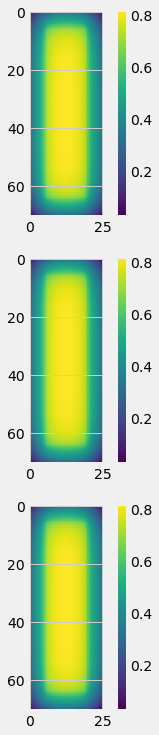

Prediction Loss: tensor(0.0015, device='cuda:0', grad_fn=<MeanBackward0>)
Input Loss: tensor(0.0010, device='cuda:0')


In [5]:
# Loss is 0.0219
# 
# 1600
# 1500 - example of very small data
# 1000 - very small nums
# 3000 - bigger numbers
#
Lf = torch.nn.L1Loss()

(inp,cmpr ,tar, _, _, _) = dataset[1600]
inp = inp.reshape(71*26).float()

rec = model(inp).float().reshape(71, 26)

fig, ax = plt.subplots(nrows=3, figsize=(4, 12))
pos = ax[0].imshow(rec.cpu().detach().numpy())
c_bar = fig.colorbar(pos, ax=ax[0])
# print(rec.min(), rec.max())


tar = tar.reshape(71, 26).float()
pos = ax[1].imshow(tar.cpu().detach().numpy())
c_bar = fig.colorbar(pos, ax=ax[1])
# print(tar.min(), tar.max())


cmpr = cmpr.reshape(71, 26).float()
pos = ax[2].imshow(cmpr.cpu().detach().numpy())
c_bar = fig.colorbar(pos, ax=ax[2])
# print(inp.min(), inp.max())

plt.show()
print("Prediction Loss:", Lf(tar, rec))

print("Input Loss:", Lf(tar, cmpr))
